In [1]:
import os
import numpy as np
from sklearn.decomposition import NMF
from sonnmf.main import base as sonnmf
from sonnmf.utils import save_results, load_results
import matplotlib.pyplot as plt

In [2]:
def sample_dirichlet(alpha, N):
    k = len(alpha)
    theta = np.zeros((N, k))
    scale = 1
    for i in range(k):
        theta[:, i] = np.random.gamma(alpha[i], scale, N)
    S = np.sum(theta, axis=1)
    theta = theta / np.tile(S.reshape(-1, 1), (1, k))
    return theta


def create_synthetic_data():
    Wt = np.array([[1, 0, 0, 1], [1, 0, 1, 0], [0, 1, 1, 0], [0, 1, 0, 1]])
    r = 4

    n = 500
    purity = 0.8
    alpha = 0.05 * np.ones((r, 1))
    Ht = sample_dirichlet(alpha, n).T
    for j in range(n):
        while np.max(Ht[:, j]) > purity:
            Ht[:, j: j+1] = sample_dirichlet(alpha, 1).T
    epsilon = 0.01
    Xt = np.dot(Wt, Ht)
    X = np.maximum(0, Xt + epsilon * np.random.randn(*Xt.shape))
    return X, Wt, Ht


def plot_3d(ax, X, Wt, W):
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X[0, :], X[1, :], X[2, :], c='b', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='r', marker='o', s=144)
    ax.scatter(W[0, :], W[1, :], W[2, :], c='m', marker='x', s=144)
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    # if filepath:
    #     plt.savefig(filepath)
    # else:
    #     plt.show()

In [29]:
RUN = True

In [3]:
data_filepath = f'../datasets/synthetic_data.npz'

if os.path.exists(data_filepath):
    data = np.load(data_filepath)
    M = data['M']
    W_true = data['W_true']
    H_true = data['H_true']
else:
    M, W_true, H_true = create_synthetic_data()
    with open(data_filepath, 'wb') as fout:
        np.savez_compressed(fout, M=M, W_true=W_true, H_true=H_true)

In [4]:
m, n = M.shape
max_iters = 10000
r = 8
ini_filepath = f'../../experimental/saved_models/synthetic/r{r}_ini.npz'

if os.path.exists(ini_filepath):
    data = np.load(ini_filepath)
    ini_W = data['ini_W']
    ini_H = data['ini_H']
else:
    ini_W = np.random.rand(m, r)
    ini_H = np.random.rand(r, n)
    with open(ini_filepath, 'wb') as fout:
        np.savez_compressed(fout, ini_W=ini_W, ini_H=ini_H)

In [32]:
# save_filepath = f'../../experimental/saved_models/toy/vanilla_r{r}_mit{max_iters}.npz'
# img_filepath = f'../../experimental/images/toy/vanilla_r{r}_mit{max_iters}.png'
# 
# if RUN:
#     model = NMF(n_components=r, init='custom', random_state=42, max_iter=max_iters)
#     W = model.fit_transform(X=M, W=ini_W.copy(), H=ini_H.copy())
#     H = model.components_
#     with open(save_filepath, 'wb') as fout:
#         np.savez_compressed(fout, W=W, H=H)
# else:
#     data = np.load(save_filepath)
#     W = data['W']
#     H = data['H']
#     plot_3d(M, W_true, W, img_filepath)

In [5]:
iters = [1, 10, 100, 1000, 10000, 20000]
_lam = 20
save_filepath = '../saved_models/synthetic/r{}_a_l{}_mit{}_h{}.npz'
img_filepath = '../../experimental/images/synthetic/r{}_a_l{}_mit{}_h{}.png'


W, H, fscores, gscores, lvals = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=iters[0], early_stop=True, verbose=False, scale_reg=True,
                                       h_update_iters=1, h_update_accelarated=0)
save_results(save_filepath.format(r, _lam, iters[0], 0), W, H, fscores, gscores, lvals)

for i, it in enumerate(iters):
    if i == 0:
        W, H, fscores, gscores, lvals = sonnmf(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=it, early_stop=True, verbose=False, scale_reg=True,
                                       h_update_iters=1, h_update_accelarated=0)
        save_results(save_filepath.format(r, _lam, it, 0), W, H, fscores, gscores, lvals)
    else:
        old_W, old_H, _, _, _ = load_results(save_filepath.format(r, _lam, iters[i - 1], 0))
        W, H, fscores, gscores, lvals = sonnmf(M, old_W.copy(), old_H.copy(), lam=_lam, itermax=it-iters[i - 1], early_stop=True, verbose=False, scale_reg=True,
                                       h_update_iters=1, h_update_accelarated=0)
        save_results(save_filepath.format(r, _lam, it, 0), W, H, fscores, gscores, lvals)
    print(it)

1
10
100
1000
10000
20000


In [ ]:
# save_filepath = '../../experimental/saved_models/toy/r{}_b_l{}_mit{}.npz'
# img_filepath = '../../experimental/images/toy/r{}_b_l{}_mit{}.png'
# 
# for _lam in lambda_vals:
#     if ~RUN:
#         W, H, fscores, gscores, lvals = nmf_son_new_2(M, ini_W.copy(), ini_H.copy(), lam=_lam, itermax=max_iters, early_stop=True, verbose=False, scale_reg=True)
#         save_results(save_filepath.format(r, _lam, max_iters), W, H, fscores, gscores, lvals)
#     else:
#         W, H, fscores, gscores, lvals = load_results(save_filepath.format(r, _lam, max_iters))
#         plot_3d(M, W_true, W, img_filepath.format(r, _lam, max_iters))
#     print(_lam)

In [ ]:
# row_labels = ['Rank 4', 'Rank 8']
# col_labels = ['Vanilla NMF', 'Vanilla NMF \n (L2 norm adjusted)', 'SONNMF']
#
# fig = plt.figure(figsize=(18, 8))
# gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.1] + len(col_labels) * [1])
#
# for i, rlabel in enumerate(row_labels):
#     txt_ax = fig.add_subplot(gs[i, 0])
#     txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=18)
#     txt_ax.axis('off')
#
# r = 4
# vW1 = np.load('../saved_models/synthetic/vanilla_r{}_mit{}.npz'.format(r, max_iters))['W']
# col_norm_vW1 = np.linalg.norm(vW1, axis=0, ord=2, keepdims=True)
# vW1_re = vW1 / col_norm_vW1
# # vH1_re = vH1 * col_norm_vW1.T
# cW1, _, _, _, _ = load_results('../saved_models/synthetic/r{}_a_l{}_mit{}.npz'.format(r, 0.0001, max_iters))
# rW1, rH1, _, _, _ = load_results('../saved_models/synthetic/r{}_b_l{}_mit{}.npz'.format(r, 10, max_iters))
# col_norm_rW1 = np.linalg.norm(rW1, axis=0, ord=2, keepdims=True)
# rW1_re = rW1 / col_norm_rW1
# # rH1_re = rH1 * col_norm_rW1.T
#
# for i, curr_W in enumerate([vW1, vW1_re, cW1]):
#     curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
#     plot_3d(curr_subplot, M, W_true, curr_W)
#     curr_subplot.set_title(col_labels[i], fontsize=18)
#
#
# r = 8
# vW2 = np.load('../saved_models/synthetic/vanilla_r{}_mit{}.npz'.format(r, max_iters))['W']
# col_norm_vW2 = np.linalg.norm(vW2, axis=0, ord=2, keepdims=True)
# vW2_re = vW2 / col_norm_vW2
# # vH2_re = vH2 * col_norm_vW2.T
# cW2, _, _, _, _ = load_results('../saved_models/synthetic/r{}_a_l{}_mit{}.npz'.format(r, 10, max_iters))
# rW2, rH2, _, _, _ = load_results('../saved_models/synthetic/r{}_b_l{}_mit{}.npz'.format(r, 100, max_iters))
# col_norm_rW2 = np.linalg.norm(rW2, axis=0, ord=2, keepdims=True)
# rW2_re = rW2 / col_norm_rW2
# # rH2_re = rH2 * col_norm_rW2.T
#
# for i, curr_W in enumerate([vW2, vW2_re, cW2]):
#     plot_3d(fig.add_subplot(gs[1, i+1], projection='3d'), M, W_true, curr_W)
#
# # adjust spacing between subplots
# fig.tight_layout(pad=1.0)
# plt.savefig('../final_results/synthetic_results.png')

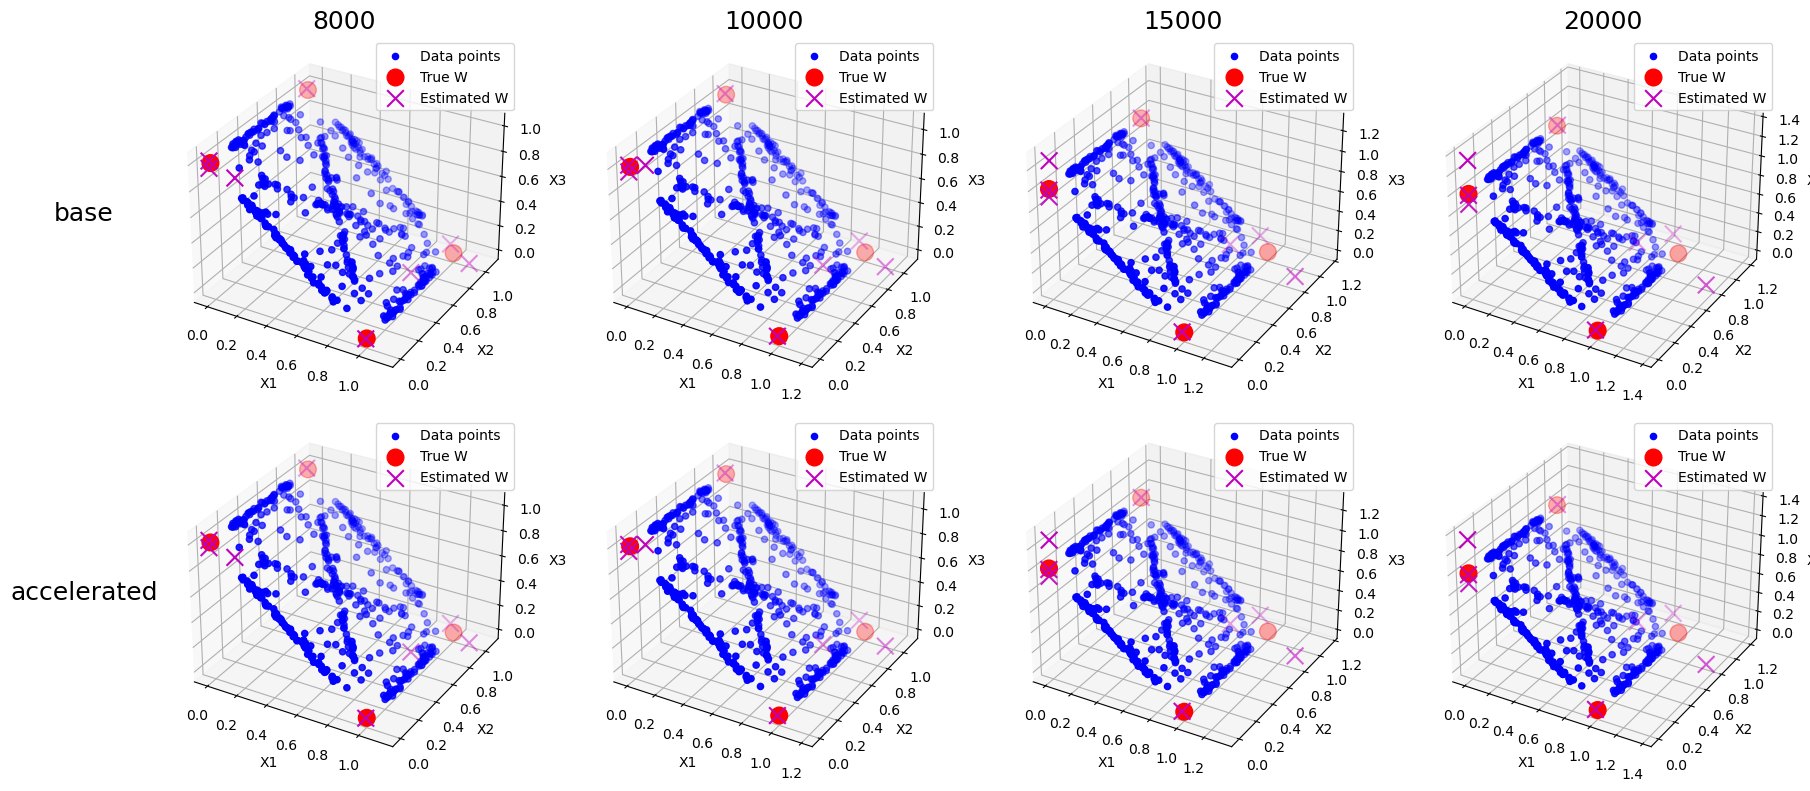

In [44]:
save_filepath = '../../experimental/saved_models/synthetic/r{}_a_l{}_mit{}_h{}.npz'
row_labels = ['base', 'accelerated']
col_labels = ['8000', '10000', '15000', '20000']

fig = plt.figure(figsize=(18, 8))
gs = fig.add_gridspec(2, len(col_labels) + 1, width_ratios=[0.1] + len(col_labels) * [1])

for i, rlabel in enumerate(row_labels):
    txt_ax = fig.add_subplot(gs[i, 0])
    txt_ax.text(0.5, 0.5, rlabel, ha='center', va='center', fontsize=18)
    txt_ax.axis('off')

r = 8
W1, _, _, _, _ = load_results(save_filepath.format(r, 20, 8000, 0))
W2, _, _, _, _ = load_results(save_filepath.format(r, 20, 10000, 0))
W3, _, _, _, _ = load_results(save_filepath.format(r, 20, 15000, 0))
W4, _, _, _, _ = load_results(save_filepath.format(r, 20, 20000, 0))

for i, curr_W in enumerate([W1, W2, W3, W4]):
    curr_subplot = fig.add_subplot(gs[0, i+1], projection='3d')
    plot_3d(curr_subplot, M, W_true, curr_W)
    curr_subplot.set_title(col_labels[i], fontsize=18)

W1, _, _, _, _ = load_results(save_filepath.format(r, 20, 8000, 1))
W2, _, _, _, _ = load_results(save_filepath.format(r, 20, 10000, 1))
W3, _, _, _, _ = load_results(save_filepath.format(r, 20, 15000, 1))
W4, _, _, _, _ = load_results(save_filepath.format(r, 20, 20000, 1))

for i, curr_W in enumerate([W1, W2, W3, W4]):
    curr_subplot = fig.add_subplot(gs[1, i+1], projection='3d')
    plot_3d(curr_subplot, M, W_true, curr_W)
    # curr_subplot.set_title(col_labels[i], fontsize=18)

# adjust spacing between subplots
fig.tight_layout(pad=1.0)
plt.savefig('../final_results/synthetic_it_sens.png')

In [53]:
def plot_3d_mod(ax, X, Wt, W, label):
    # fig = plt.figure()
    # ax = fig.add_subplot(111, projection='3d')
    # ax.scatter(X[0, :], X[1, :], X[2, :], c='lightblue', marker='o')
    ax.scatter(Wt[0, :], Wt[1, :], Wt[2, :], c='red', marker='o', s=144)
    # ax.scatter(W[0, :], W[1, :], W[2, :], c='black', marker='x', s=144)
    ax.scatter(W[0, 1], W[1, 1], W[2, 1], c='black', marker='x', s=144)
    ax.text(W[0, 1] - 0.1, W[1, 1] - 0.1, W[2, 1] - 0.1, label)

    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.set_zlabel('X3')
    ax.legend(['Data points', 'True W', 'Estimated W'])
    ax.grid(True)
    # if filepath:
    #     plt.savefig(filepath)
    # else:
    #     plt.show()

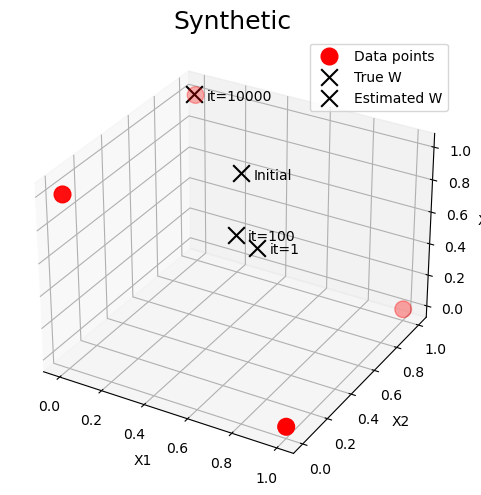

In [72]:
save_filepath = '../../experimental/saved_models/synthetic/r{}_a_l{}_mit{}_h{}.npz'
plt_title = ['Synthetic']
it_labels = ['Initial', 'it=1', 'it=100', 'it=10000']
fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

r = 8
# W1, _, _, _, _ = load_results(save_filepath.format(r, 20, 0, 0))
W2, _, _, _, _ = load_results(save_filepath.format(r, 20, 1, 0))
# W3, _, _, _, _ = load_results(save_filepath.format(r, 20, 10, 0))
W4, _, _, _, _ = load_results(save_filepath.format(r, 20, 100, 0))
# W5, _, _, _, _ = load_results(save_filepath.format(r, 20, 1000, 0))
W6, _, _, _, _ = load_results(save_filepath.format(r, 20, 10000, 0))
# W7, _, _, _, _ = load_results(save_filepath.format(r, 20, 20000, 0))

# ax.scatter(M[0, :], M[1, :], M[2, :], c='lightblue', marker='o')
ax.scatter(W_true[0, :], W_true[1, :], W_true[2, :], c='red', marker='o', s=144)

for i, curr_W in enumerate([ini_W, W2, W4, W6]):
    ax.scatter(curr_W[0, 1], curr_W[1, 1], curr_W[2, 1], c='black', marker='x', s=144)
    ax.text(curr_W[0, 1], curr_W[1, 1] + 0.1, curr_W[2, 1] - 0.1, it_labels[i])
ax.set_title(plt_title[0], fontsize=18)
ax.set_xlabel('X1')
ax.set_ylabel('X2')
ax.set_zlabel('X3')
ax.legend(['Data points', 'True W', 'Estimated W'])
ax.grid(True)

# adjust spacing between subplots
fig.tight_layout(pad=1.0)
plt.savefig('../final_results/synthetic_timeseries_singlefig_1pt.png')

In [17]:
W.shape

(4, 8)

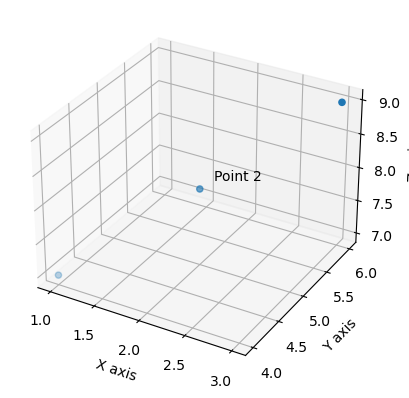

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# plot some data points
x = [1, 2, 3]
y = [4, 5, 6]
z = [7, 8, 9]
ax.scatter(x, y, z)

# add a label next to one of the data points
label = 'Point 2'
idx = 1  # the index of the data point to label
ax.text(x[idx]+0.1, y[idx]+0.1, z[idx]+0.1, label)

# set labels for the axes
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')

plt.show()
